v3 - using video, taking snapshot, using lego bricks and webcam mounted low above table

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop
import random

In [35]:
# Webcam index (change if needed)
CAMERA_INDEX = 1

# Parameters
CIRCLE_RADIUS = 20
CELL_SIZE = 10
PATH_COLOR = (0, 0, 0)  # Black

# Color detection ranges (HSV)
COLOR_RANGES = {
    'green': ([30, 40, 40], [90, 255, 255]),      # Start
    'blue': ([90, 50, 50], [130, 255, 255]),      # End (wider range for dark blue)
    'orange': ([5, 100, 100], [25, 255, 255])     # Obstacles
}



In [36]:
def capture_image_from_webcam(index=1):
    cap = cv2.VideoCapture(index)
    if not cap.isOpened():
        raise RuntimeError("Webcam not found or could not be opened.")

    print("Press SPACE to capture image")
    captured_frame = None

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break
        cv2.imshow("Live Feed - Press SPACE to capture", frame)

        key = cv2.waitKey(1)
        if key % 256 == 32:  # SPACE key
            captured_frame = frame
            print("Image captured")
            break
        elif key == 27:  # ESC key
            print("Canceled")
            break

    cap.release()
    cv2.destroyAllWindows()

    if captured_frame is None:
        raise RuntimeError("No frame captured. Check your camera connection.")

    return captured_frame


In [37]:
def detect_circles_and_obstacles(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Start (green)
    start_mask = cv2.inRange(hsv, np.array(COLOR_RANGES['green'][0]), np.array(COLOR_RANGES['green'][1]))
    start_coords = cv2.moments(start_mask)
    if start_coords["m00"] == 0:
        raise ValueError("Start point (green) not found.")
    start = (int(start_coords["m10"] / start_coords["m00"]),
             int(start_coords["m01"] / start_coords["m00"]))

    # End (blue)
    end_mask = cv2.inRange(hsv, np.array(COLOR_RANGES['blue'][0]), np.array(COLOR_RANGES['blue'][1]))
    end_coords = cv2.moments(end_mask)
    if end_coords["m00"] == 0:
        raise ValueError("End point (blue) not found.")
    end = (int(end_coords["m10"] / end_coords["m00"]),
           int(end_coords["m01"] / end_coords["m00"]))

    # Obstacles (orange)
    orange_mask = cv2.inRange(hsv, np.array(COLOR_RANGES['orange'][0]), np.array(COLOR_RANGES['orange'][1]))

    return start, end, orange_mask


In [38]:
# === Inflate Obstacles with Dilation ===
def inflate_obstacles_cv(mask, robot_radius_pixels=20):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (robot_radius_pixels, robot_radius_pixels))
    inflated_mask = cv2.dilate(mask, kernel, iterations=1)
    return inflated_mask

# === Resize Image for Pathfinding Grid ===
def resize_for_pathfinding(mask, factor=10):
    small = cv2.resize(mask, (mask.shape[1] // factor, mask.shape[0] // factor), interpolation=cv2.INTER_NEAREST)
    return (small > 0).astype(np.uint8)


In [39]:
def pixel_to_grid(pt, factor=10):
    return pt[0] // factor, pt[1] // factor

def grid_to_pixel(pt, factor=10):
    return pt[0] * factor + factor // 2, pt[1] * factor + factor // 2

# === A* Pathfinding ===
def astar(grid, start, end):
    neighbors = [(0,1), (1,0), (-1,0), (0,-1), (-1,-1), (-1,1), (1,-1), (1,1)]
    def heuristic(a, b):
        return ((a[0]-b[0])**2 + (a[1]-b[1])**2)**0.5

    close_set = set()
    came_from = {}
    direction_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, end)}
    open_heap = [(fscore[start], start)]

    while open_heap:
        _, current = heappop(open_heap)
        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        close_set.add(current)
        for dx, dy in neighbors:
            neighbor = (current[0]+dx, current[1]+dy)
            direction = (dx, dy)
            if not (0 <= neighbor[0] < grid.shape[1] and 0 <= neighbor[1] < grid.shape[0]):
                continue
            if grid[neighbor[1], neighbor[0]] == 1:
                continue

            move_cost = 1.4 if dx != 0 and dy != 0 else 1
            tentative_gscore = gscore[current] + move_cost

            prev_dir = direction_from.get(current)
            if prev_dir and prev_dir != direction:
                tentative_gscore += 0.5

            if neighbor in close_set and tentative_gscore >= gscore.get(neighbor, float("inf")):
                continue

            if tentative_gscore < gscore.get(neighbor, float("inf")):
                came_from[neighbor] = current
                direction_from[neighbor] = direction
                gscore[neighbor] = tentative_gscore
                fscore[neighbor] = tentative_gscore + heuristic(neighbor, end)
                heappush(open_heap, (fscore[neighbor], neighbor))

    return []

In [40]:
class SimulatedRobot:
    def __init__(self, start_pos):
        self.pos = start_pos
        self.path_index = 0

    def move_toward(self, target):
        if self.pos == target:
            return "REACHED"
        x, y = self.pos
        tx, ty = target
        if x < tx: x += 1
        elif x > tx: x -= 1
        if y < ty: y += 1
        elif y > ty: y -= 1
        self.pos = (x, y)
        return "REACHED" if self.pos == target else "MOVING"

In [41]:
# === MAIN ===

# Capture image from camera
image = capture_image_from_webcam(index=CAMERA_INDEX)

# Detect start, end, and raw obstacle mask
start_pixel, end_pixel, obstacle_mask = detect_circles_and_obstacles(image)

# --- Inflate obstacles BEFORE resizing ---
inflated_mask = inflate_obstacles_cv(obstacle_mask, robot_radius_pixels=20)

# Resize inflated obstacle mask to grid
obstacle_grid = resize_for_pathfinding(inflated_mask, factor=CELL_SIZE)

# Convert start/end points to grid
start_grid = pixel_to_grid(start_pixel, factor=CELL_SIZE)
end_grid = pixel_to_grid(end_pixel, factor=CELL_SIZE)

# Run A* on inflated grid
path = astar(obstacle_grid, start_grid, end_grid)

Press SPACE to capture image
Image captured


In [42]:
# === Direction Change Detection ===
direction_changes = []
last_dir = None
for i in range(1, len(path)):
    dx = path[i][0] - path[i-1][0]
    dy = path[i][1] - path[i-1][1]
    direction = (dx, dy)
    if direction != last_dir:
        direction_changes.append(path[i-1])
        last_dir = direction

print("\n=== Direction Changes Along Path ===")
for pt in direction_changes:
    print(pt)


=== Direction Changes Along Path ===
(56, 40)
(42, 26)
(23, 26)
(13, 16)
(13, 14)
(8, 9)


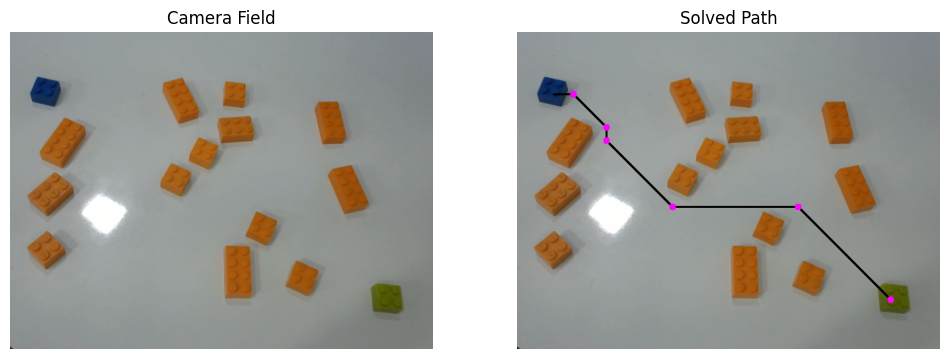

In [43]:
# === Visualization ===
solved = image.copy()
for i in range(1, len(path)):
    pt1 = grid_to_pixel(path[i-1], factor=CELL_SIZE)
    pt2 = grid_to_pixel(path[i], factor=CELL_SIZE)
    cv2.line(solved, pt1, pt2, PATH_COLOR, 2)

for pt in direction_changes:
    px = grid_to_pixel(pt, factor=CELL_SIZE)
    cv2.circle(solved, px, 5, (255, 0, 255), -1)

# Display side-by-side
field_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
solved_rgb = cv2.cvtColor(solved, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Camera Field")
plt.imshow(field_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Solved Path")
plt.imshow(solved_rgb)
plt.axis('off')
plt.show()

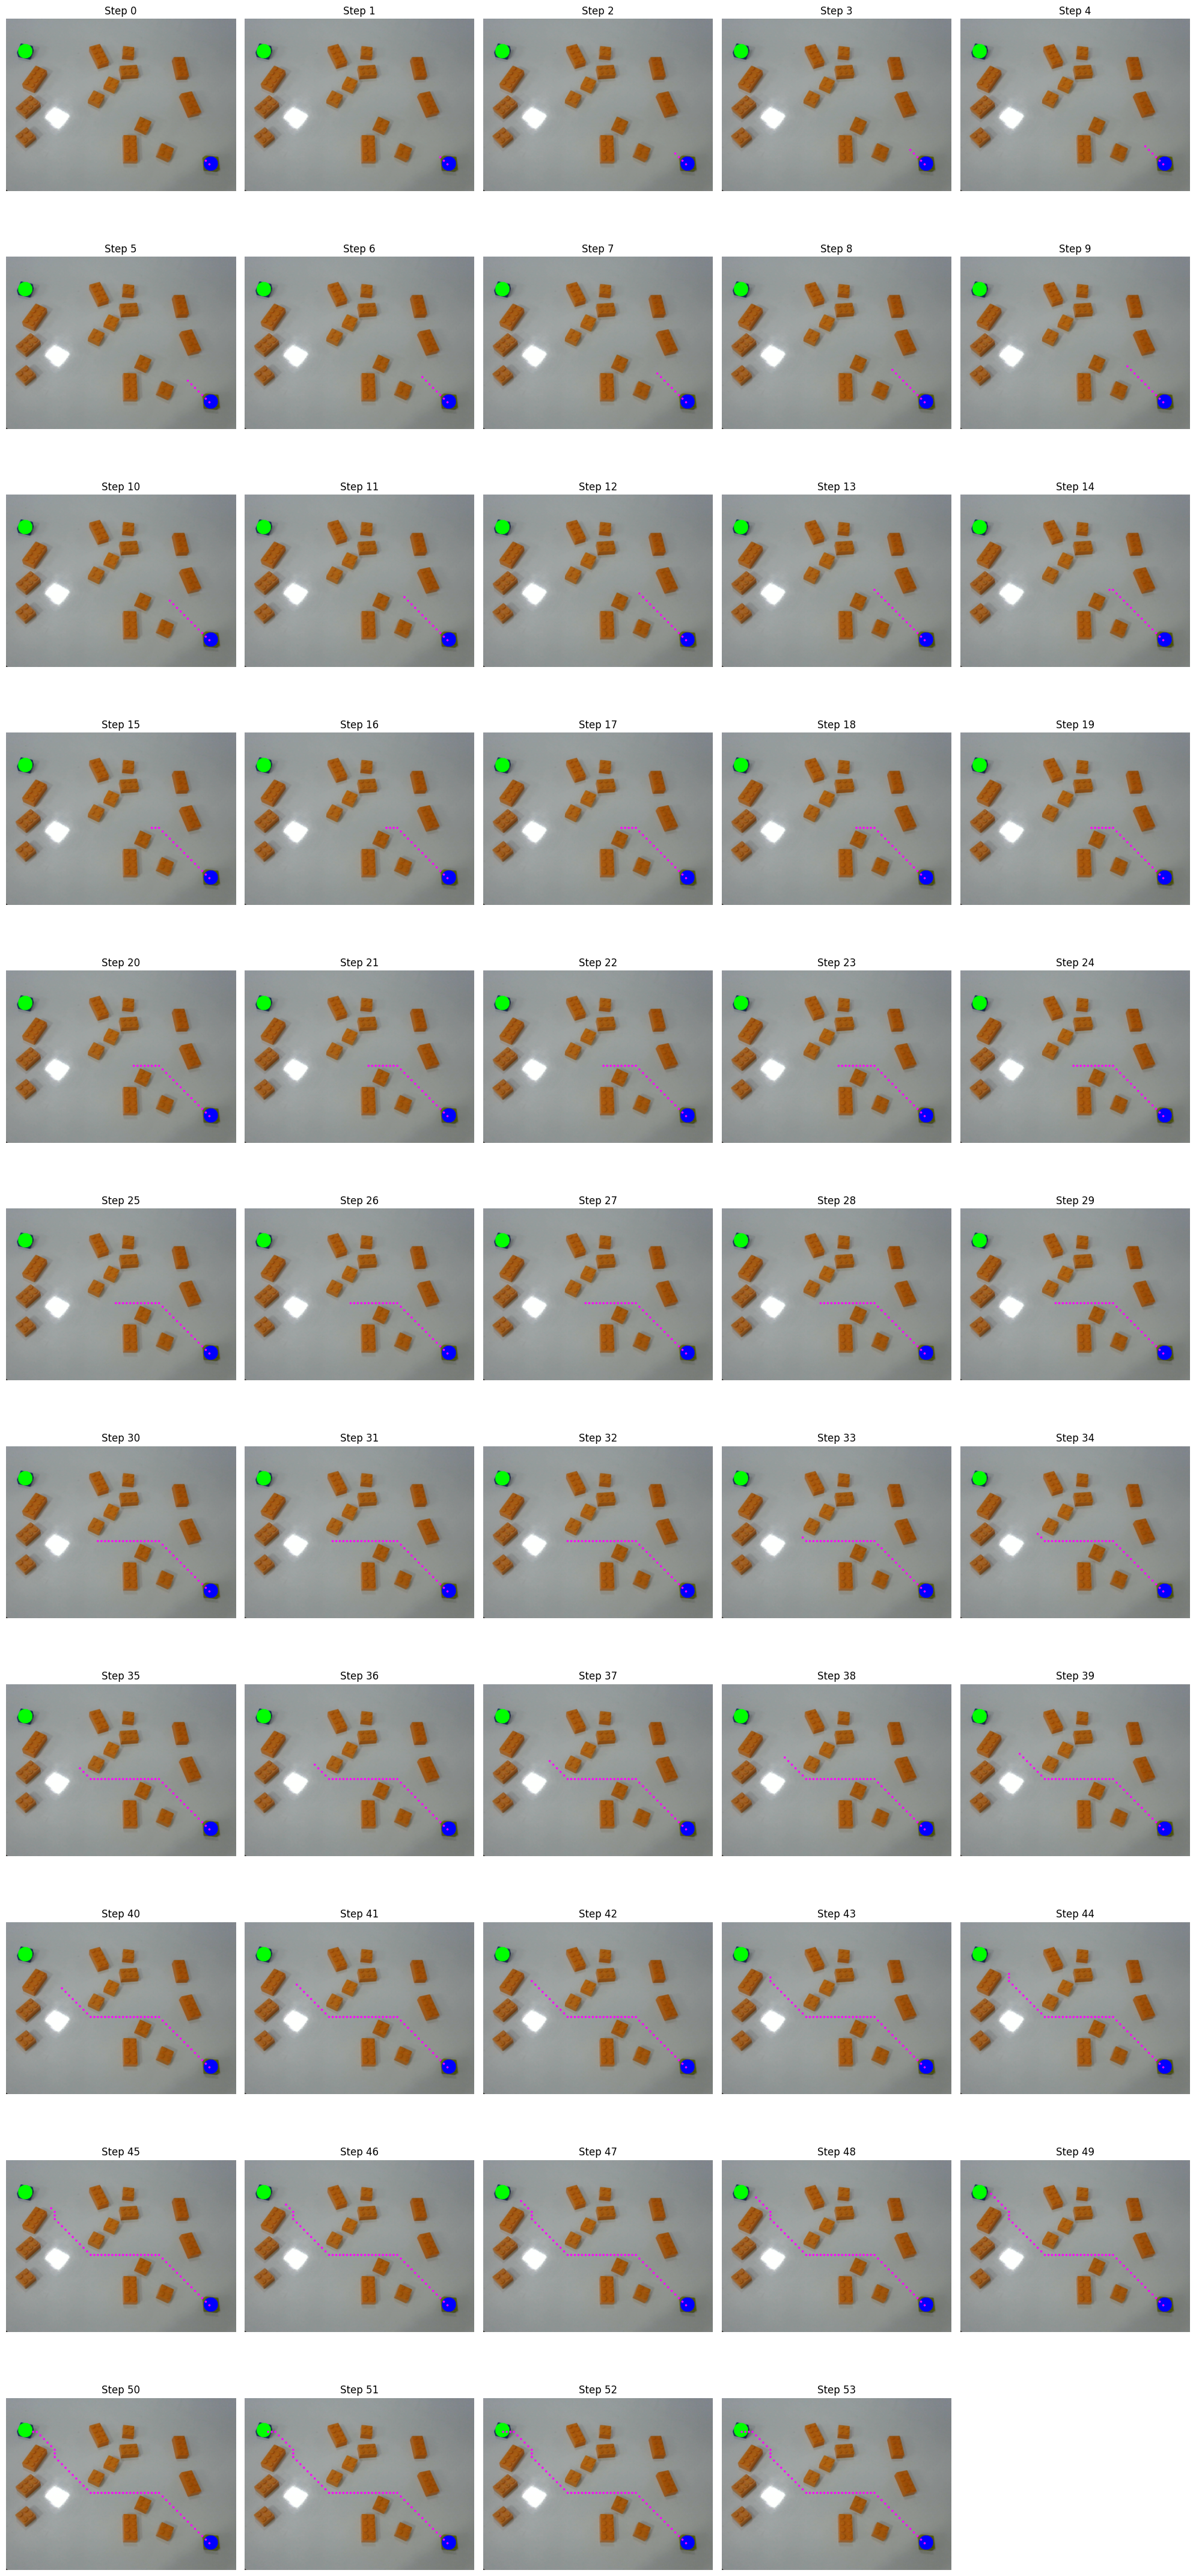

In [44]:
# === Robot Simulation ===
frames = []
robot = SimulatedRobot(start_grid)
step = 0
while robot.path_index < len(path):
    prev = robot.pos
    target = path[robot.path_index]
    robot.move_toward(target)

    if robot.pos == target:
        robot.path_index += 1

    frame = image.copy()
    cv2.circle(frame, start_pixel, CIRCLE_RADIUS, (255, 0, 0), -1)
    cv2.circle(frame, end_pixel, CIRCLE_RADIUS, (0, 255, 0), -1)

    for pt in path[:robot.path_index+1]:
        px = grid_to_pixel(pt, factor=CELL_SIZE)
        cv2.circle(frame, px, 3, (255, 0, 255), -1)

    robot_px = grid_to_pixel(robot.pos, factor=CELL_SIZE)
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    step += 1

# Plot robot steps
cols = min(len(frames), 5)
rows = (len(frames) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))
for i, f in enumerate(frames):
    plt.subplot(rows, cols, i + 1)
    plt.title(f"Step {i}")
    plt.imshow(f)
    plt.axis('off')
plt.tight_layout()
plt.show()